# 📊 CNN Model for 5G Throughput Prediction
**Target**: Smoothed `Throughput`

- Based on CNN for temporal feature extraction
- Includes rolling window sequence generation
- Uses smoothed `Throughput` as prediction target
- Evaluation: predicted vs true vs original throughput


In [4]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


### 🔹 1. Load and preprocess the dataset

In [5]:

# Corrected local path
df = pd.read_csv(r"C:\Users\axxiv\Desktop\PI\mm-5G-prepared.csv")

# Apply smoothing on the throughput column
df['Throughput_smoothed'] = df['Throughput'].rolling(window=5, min_periods=1).mean()


### 🔹 2. Normalize and prepare sequences for CNN input

In [7]:

features = df.columns.drop(['Throughput', 'Throughput_smoothed'])
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

class TimeSeriesCnnDataset(Dataset):
    def __init__(self, df, input_len=48, output_len=1):
        self.X, self.y = [], []
        for i in range(len(df) - input_len - output_len + 1):
            x = df[features].iloc[i:i+input_len].values.T  # shape: (features, timesteps)
            y = df['Throughput_smoothed'].iloc[i+input_len:i+input_len+output_len].values
            self.X.append(x)
            self.y.append(y)
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

input_len = 48
output_len = 1

dataset = TimeSeriesCnnDataset(df, input_len, output_len)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)


### 🔹 3. Define CNN model

In [ ]:

class CNNModel(nn.Module):
    def __init__(self, in_channels, seq_len, output_len):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32, output_len)

    def forward(self, x):
        x = self.relu(self.conv1(x))       # (batch, 32, seq_len)
        x = self.pool(x)                   # (batch, 32, 1)
        x = self.flatten(x)                # (batch, 32)
        x = self.fc(x)                     # (batch, output_len)
        return x

model = CNNModel(in_channels=len(features), seq_len=input_len, output_len=output_len)


### 🔹 4. Train the model

In [ ]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []

for epoch in range(25):
    model.train()
    batch_losses = []
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

    model.eval()
    with torch.no_grad():
        val_loss = np.mean([loss_fn(model(xb), yb).item() for xb, yb in val_dl])
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")


Epoch 1: Train Loss = 144350.4820, Val Loss = 146055.2387
Epoch 2: Train Loss = 144232.4235, Val Loss = 145976.9854
Epoch 3: Train Loss = 144090.9644, Val Loss = 145761.4771
Epoch 4: Train Loss = 144016.9204, Val Loss = 145717.9626
Epoch 5: Train Loss = 143839.7330, Val Loss = 145642.7490
Epoch 6: Train Loss = 143701.8792, Val Loss = 145677.6252
Epoch 7: Train Loss = 143589.5965, Val Loss = 145232.6167
Epoch 8: Train Loss = 143515.6617, Val Loss = 145180.6876
Epoch 9: Train Loss = 143366.7212, Val Loss = 145145.9338
Epoch 10: Train Loss = 143209.3931, Val Loss = 144863.5490
Epoch 11: Train Loss = 143142.8443, Val Loss = 144732.2108
Epoch 12: Train Loss = 142979.9282, Val Loss = 144928.9484
Epoch 13: Train Loss = 142882.4028, Val Loss = 144494.2625
Epoch 14: Train Loss = 142792.6176, Val Loss = 144705.4304
Epoch 15: Train Loss = 142659.9087, Val Loss = 144284.7842
Epoch 16: Train Loss = 142560.6927, Val Loss = 144093.3308
Epoch 17: Train Loss = 142448.2534, Val Loss = 144016.8131
Epoch 

### 🔹 5. Plot loss evolution

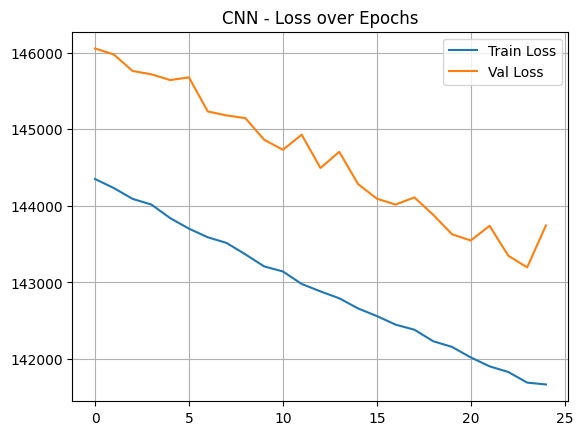

In [ ]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("CNN - Loss over Epochs")
plt.grid(True)
plt.show()


### 🔹 6. Final prediction vs truth vs original throughput

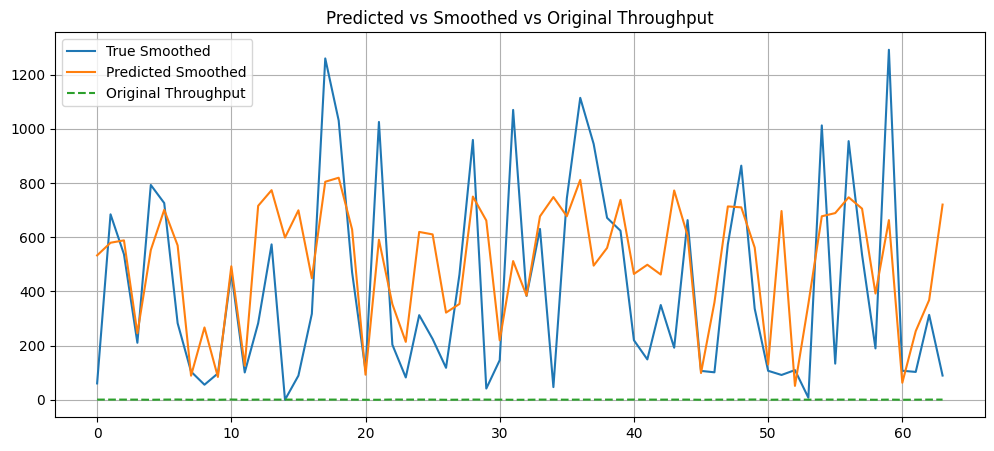

In [ ]:

model.eval()
xbatch, ytrue = next(iter(val_dl))
with torch.no_grad():
    ypred = model(xbatch).squeeze().numpy()

plt.figure(figsize=(12,5))
plt.plot(ytrue.squeeze().numpy(), label='True Smoothed')
plt.plot(ypred, label='Predicted Smoothed')
plt.plot(xbatch[:, -1, df.columns.get_loc('Throughput') - 2].numpy(), label='Original Throughput', linestyle='--')
plt.title('Predicted vs Smoothed vs Original Throughput')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Full evaluation over validation set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        pred = model(xb).squeeze()
        y_true.extend(yb.squeeze().cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

# Metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("📊 CNN Model Evaluation:")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


NameError: name 'model' is not defined